In [ ]:
pip install pysbd
pip install sentence-transformers
pip install datasets
pip install evaluate
pip install bert_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import pandas as pd
import regex as re
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
from difflib import SequenceMatcher
from collections import Counter
from functools import partial

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import pysbd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AdamWeightDecay
from transformers import TFAutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers.keras_callbacks import KerasMetricCallback
import evaluate
import bert_score

# from transcript_utils import get_transcription, semantic_segmentation, extract_features

# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
file_path = '/content/drive/MyDrive/682-project/data/metadata.tsv'

# Import Pandas
import pandas as pd

# Read the TSV file as a DataFrame
metadata_training = pd.read_csv(file_path, sep='\t')
print("Columns: ", metadata_training.columns)
print("Shape: ", metadata_training.shape)

Columns:  Index(['show_uri', 'show_name', 'show_description', 'publisher', 'language',
       'rss_link', 'episode_uri', 'episode_name', 'episode_description',
       'duration', 'show_filename_prefix', 'episode_filename_prefix'],
      dtype='object')
Shape:  (105360, 12)


Episode Duration Stats:
count    105360.000000
mean         33.845715
std          22.735674
min           0.175317
25%          13.552638
50%          31.643375
75%          50.446825
max         304.953900
Name: duration, dtype: float64


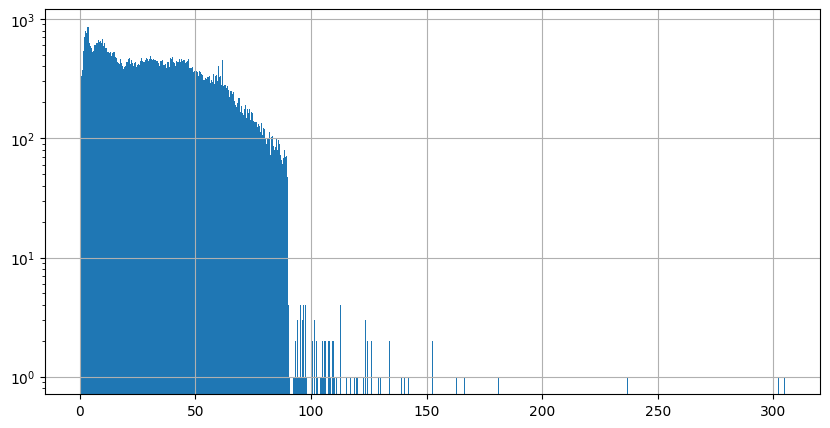

In [ ]:
print("Episode Duration Stats:\n"
      f"{metadata_training['duration'].describe()}")
metadata_training['duration'].hist(bins=1000, figsize=(10,5), log=True)
plt.show()

Statistics about number of episodes per show:
count    18376.000000
mean         5.733566
std         19.310585
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1072.000000
dtype: float64


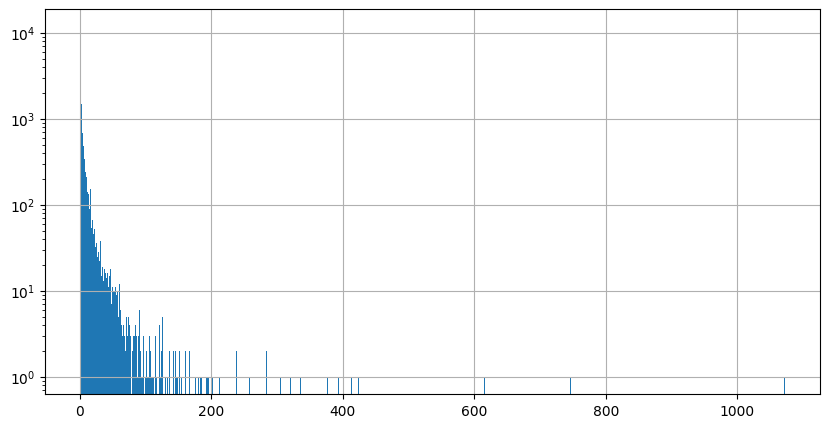

In [ ]:
show_episodes = metadata_training.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
show_n_episodes = {k: len(v) for k, v in show_episodes.items()}
print("Statistics about number of episodes per show:\n"
      f"{pd.Series(show_n_episodes.values()).describe()}")
pd.Series(show_n_episodes.values()).hist(bins=1000, figsize=(10,5), log=True)
plt.show()


Cleaning the descriptions of episodes to have labeled training set

1. Droping NaN values

In [ ]:
print("Before dropping NaN values: \n", metadata_training.isna().any())
metadata_training.dropna(subset=['episode_description', 'show_description'], inplace=True)
print("\nAfter dropping NaN values:\n", metadata_training.isna().any())

Before dropping NaN values: 
 show_uri                   False
show_name                  False
show_description            True
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description         True
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool

After dropping NaN values:
 show_uri                   False
show_name                  False
show_description           False
publisher                  False
language                   False
rss_link                   False
episode_uri                False
episode_name               False
episode_description        False
duration                   False
show_filename_prefix       False
episode_filename_prefix    False
dtype: bool


In [ ]:
metadata_gold = pd.read_csv('/content/drive/MyDrive/682-project/data/150gold.tsv', sep='\t')

quality = {
    'B': 1,
    'F': 2,
    'G': 3,
    'E': 4
}

# convert egfb columns to a quality score
egfb_columns = ['EGFB', 'EGFB.1', 'EGFB.2', 'EGFB.3', 'EGFB.4', 'EGFB.5']
egfb_to_quality = metadata_gold[egfb_columns].applymap(lambda x: quality[x])

# remove rows with no quality > 1
egfb_to_quality = egfb_to_quality[[any(row > 1) for row in egfb_to_quality.values]]

# select the best transcript for each episode
best_egfb = egfb_to_quality.apply(lambda x: x.idxmax(), axis=1)
best_summary = [metadata_gold.iloc[i, np.argwhere(metadata_gold.columns == egfb)[0][0] - 1] for i, egfb in best_egfb.iteritems()]

metadata_gold = metadata_gold.loc[best_egfb.index]
metadata_gold['best_summary'] = best_summary

# create a dictionary of the best summary for each episode
gold_summaries = {row['episode id']: row['best_summary'] for i, row in metadata_gold.iterrows()}

<ipython-input-6-62b63caef42a>:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  best_summary = [metadata_gold.iloc[i, np.argwhere(metadata_gold.columns == egfb)[0][0] - 1] for i, egfb in best_egfb.iteritems()]


In [ ]:
# substitute the episode descriptions correspondent to the episodes in the gold set with the best summary
for i, row in metadata_training.iterrows():
    if row['episode_uri'] in gold_summaries.keys():
        metadata_training.at[i, 'episode_description'] = gold_summaries[row['episode_uri']]

In [ ]:
def compute_document_frequencies(descriptions):
    """
    Compute the document frequencies in the whole dataset descriptions

    Parameters
    ----------
    descriptions : list of str
        The descriptions of the episodes

    Returns
    -------
    A dictionary of word frequencies
    """
    seg = pysbd.Segmenter(language="en", clean=False)

    # get a set of words contained in each description (words are all lowercase)
    flattened_descriptions = []
    for description in tqdm(descriptions, desc="Computing word frequencies"):
        description_set = set()
        for sentence in seg.segment(description):
            description_set.update([word.lower() for word in word_tokenize(sentence)])
        flattened_descriptions.extend(list(description_set))

    counts = pd.Series(Counter(flattened_descriptions))  # Get counts and transform to Series
    return counts

# compute the document frequencies that will be used to compute the sentence salience score
document_frequencies = compute_document_frequencies(metadata_training['episode_description'])

Computing word frequencies: 100%|██████████| 105153/105153 [09:19<00:00, 187.95it/s]


In [ ]:
# store the old dataframe to make comparisons
metadata_train_old = metadata_training.copy()

In [ ]:
def remove_boilerplate(description):
    """
    Remove boilerplate from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without boilerplate (str)
    """
    boilerplate_re = re.compile(r"---.*")
    return boilerplate_re.sub("", description)

def remove_link_or_sponsors(description):
    """
    Remove sentences containing links and sponsors or username and hashtag from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without links and sponsors (str)
    """
    username_and_hashtag_re = re.compile(r"(\B@\w+|\B#\w+)")
    links_or_sponsors_re = re.compile(
        r"(http|https|[pP]atreon|[eE]mail|[dD]onate|IG|[iI]nstagram|[fF]acebook|[yY]outube|[tT]witter|[dD]iscord|[fF]ollow|[sS]potify)"
    )

    # remove username and hashtag
    description = username_and_hashtag_re.sub(" ", description)

    # remove sentences containing links and sponsors
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    sentences = [sentence for sentence in sentences if not links_or_sponsors_re.search(sentence)]
    return " ".join(sentences)

def remove_emojii(description):
    """
    Remove emojii from the episode description

    Parameters
    ----------
    description : str
        The episode description

    Returns
    -------
    A description without emojii (str)
    """
    emoji_re = re.compile(r"[^\x00-\x7F]+")
    return emoji_re.sub(" ", description)

print("\nRemoving boilerplate from the episode descriptions:")
metadata_training['episode_description'] = metadata_training['episode_description'].progress_map(remove_boilerplate)

print("Removing links and sponsors from the episode descriptions:")
metadata_training['episode_description'] = metadata_training['episode_description'].progress_map(remove_link_or_sponsors)

print("Removing emojii from the episode descriptions:")
metadata_training['episode_description'] = metadata_training['episode_description'].progress_map(remove_emojii)


Removing boilerplate from the episode descriptions:


100%|██████████| 105153/105153 [00:02<00:00, 45449.16it/s]


Removing links and sponsors from the episode descriptions:


100%|██████████| 105153/105153 [07:13<00:00, 242.83it/s]


Removing emojii from the episode descriptions:


100%|██████████| 105153/105153 [00:00<00:00, 134866.54it/s]


In [ ]:
# see a few examples of comparisons between the old and new descriptions
samples = [137, 172]
print("\nExamples of comparisons before and after removing sponsors and links:")
for i in samples:
        print("BEFORE:"
                f"\n\t- {metadata_train_old['episode_description'].iloc[i]}")
        print("AFTER:"
                f"\n\t- {metadata_training['episode_description'].iloc[i]}")
        print("\n")


Examples of comparisons before and after removing sponsors and links:
BEFORE:
	- If you like ASMR you will love this White Noise Machine on Amazon! Tap here to check it out! If you enjoyed this make sure to give us a 5 star rating!  ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/AdamDino/support
AFTER:
	- If you like ASMR you will love this White Noise Machine on Amazon!  Tap here to check it out!  If you enjoyed this make sure to give us a 5 star rating!  


BEFORE:
	- Danielle and Jessi could talk your ears off when it comes to this topic. Episode 004 is all about their skincare routines, products they love, and tips and tricks for feeling radiant and confident in your own skin. Follow them @basicallyorganicpodcast (and @jessimechler @itsdaniellebridges) for tags of all the brands they’re currently loving! Rate and subscribe!!   ---   Support this podcast: https://anchor.fm/basicallyorg

In [ ]:
def sentence_salience_score(sentence, num_descriptions, document_frequencies):
    """
    Compute the salience score of a sentence by summing over word IDF scores.
    Only alphabetic words that are longer that one character and are neither stop words nor words like 'episode' or 'podcast'
    are considered when computing sentence salience scores.

    Parameters
    ----------
    sentence : str
        The sentence to compute the salience score for
    num_descriptions : int
        The number of descriptions in the dataset
    document_frequencies : pandas.Series
        The document frequencies in the whole dataset descriptions

    Returns
    -------
    The salience score of the sentence (float)
    """
    idf_scores = []
    tokenized_sentence = word_tokenize(sentence)

    # compute IDF scores for each word in the sentence and sum them up

    for word in tokenized_sentence:
        lower_world = word.lower()
        # consider only alphabetic words, and remove stop words, single character
        if lower_world in document_frequencies.keys() and lower_world.isalpha() and lower_world not in stopwords.words('english') and len(lower_world) > 1 and lower_world not in ['episode', 'podcast']:
            # get document frequency
            df = document_frequencies[lower_world]

            # compute idf score
            idf_score = np.log(num_descriptions/df)
            idf_scores.append(idf_score)

    idf_scores = np.array(idf_scores)
    salience_score = idf_scores.mean() if len(idf_scores)>0 else 0.0
    return salience_score

def remove_unuseful_sentences(description, num_descriptions, word_frequencies, threshold=3.6):
    """
    Remove sentences that are not useful for the transcriptions

    Parameters
    ----------
    description : str
        The episode description
    num_descriptions : int
        The number of descriptions in the dataset
    word_frequencies : pandas.Series
        The word frequencies in the whole dataset descriptions
    threshold : double
        The threshold for the salience score of a sentence to be considered useful

    Returns
    -------
    A description without unuseful sentences (str)
    """
    # segment the text into sentences
    seg = pysbd.Segmenter(language="en", clean=False)
    sentences = seg.segment(description)
    # remove sentences that are not useful for the transcriptions
    sentences = [sentence for sentence in sentences if sentence_salience_score(sentence, num_descriptions, word_frequencies) > threshold]
    return " ".join(sentences)

metadata_training['episode_description'] = metadata_training['episode_description'].progress_map(lambda x: remove_unuseful_sentences(x, metadata_training.shape[0], document_frequencies))

100%|██████████| 105153/105153 [18:00<00:00, 97.36it/s]


In [ ]:
# see a few examples of comparisons between the old and new descriptions
samples = [137, 172]
print("\nExamples of comparisons before and after removing unuseful sentences:")
for i in samples:
        print("BEFORE:"
                f"\n\t- {metadata_train_old['episode_description'].iloc[i]}")
        print("AFTER:"
                f"\n\t- {metadata_training['episode_description'].iloc[i]}")
        print("\n")


Examples of comparisons before and after removing unuseful sentences:
BEFORE:
	- If you like ASMR you will love this White Noise Machine on Amazon! Tap here to check it out! If you enjoyed this make sure to give us a 5 star rating!  ---   This episode is sponsored by  · Anchor: The easiest way to make a podcast.  https://anchor.fm/app  Support this podcast: https://anchor.fm/AdamDino/support
AFTER:
	- If you like ASMR you will love this White Noise Machine on Amazon!   Tap here to check it out!  


BEFORE:
	- Danielle and Jessi could talk your ears off when it comes to this topic. Episode 004 is all about their skincare routines, products they love, and tips and tricks for feeling radiant and confident in your own skin. Follow them @basicallyorganicpodcast (and @jessimechler @itsdaniellebridges) for tags of all the brands they’re currently loving! Rate and subscribe!!   ---   Support this podcast: https://anchor.fm/basicallyorganicpodcast/support
AFTER:
	- Danielle and Jessi could tal

In [ ]:
def check_lenght_brass(episode, upper_bound=750, lower_bound=20):
    """
    Check if the episode descriptions is not too long (> 750 characters) or not too short (< 20 characters)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    upper_bound : int
        The upper bound of the episode description length
    lower_bound : int
        The lower bound of the episode description length

    Returns
    -------
    Boolean indicating if the episode description is long enough
    """
    return len(episode['episode_description']) <= upper_bound and len(episode['episode_description']) >= lower_bound

def description_similarity(a, b):
    """
    Measure the overlapping between two descriptions

    Parameters
    ----------
    a : str
        The first description
    b : str
        The second description

    Returns
    -------
    Value indicating the overlapping between the two descriptions
    """
    return SequenceMatcher(None, a, b).ratio()

def check_show_description_overlap_brass(episode, thresh=0.5):
    """
    Check if the episode descriptions overlapping with the show description is not too high (< 0.5)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    thresh : float
        The threshold of the overlap between the episode description and the show description

    Returns
    -------
    Boolean indicating if the episode description is different enough from the show description
    """
    return description_similarity(episode['show_description'], episode['episode_description']) < thresh

def check_other_description_overlap_brass(episode, show_episodes, thresh=0.6):
    """
    Check if the episode descriptions overlapping with the other description in the same show is not too high (< 0.6)

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    show_episodes : dict
        A dictionary of the episodes of the same show
    thresh : float
        The threshold of the overlap between the episode description and the other description

    Returns
    -------
    Boolean indicating if the episode description is different enough from the other description
    """
    for other_prefix, other_description in show_episodes[episode['show_filename_prefix']]:
        if other_prefix != episode['episode_filename_prefix'] and description_similarity(episode['episode_description'], other_description) > thresh and len(episode['episode_description']) < len(other_description):
            return False
    return True


brass_set_lenght = metadata_training[metadata_training.progress_apply(check_lenght_brass, axis=1)]
print(f"Removed {len(metadata_training) - len(brass_set_lenght)} episodes ({(100-(len(brass_set_lenght)/len(metadata_training)*100)):.2f}%) because of too long or too short descriptions")

brass_set_show_overlap = brass_set_lenght[brass_set_lenght.progress_apply(check_show_description_overlap_brass, axis=1)]
print(f"Removed {len(brass_set_lenght) - len(brass_set_show_overlap)} episodes ({(100-(len(brass_set_show_overlap)/len(brass_set_lenght)*100)):.2f}%) because of too high overlap with the show description")

show_episodes = brass_set_show_overlap.groupby(['show_filename_prefix']).apply(lambda x: list(zip(x['episode_filename_prefix'], x['episode_description']))).to_dict()
brass_set = brass_set_show_overlap[brass_set_show_overlap.progress_apply(lambda x: check_other_description_overlap_brass(x, show_episodes), axis=1)]
print(f"Removed {len(brass_set_show_overlap) - len(brass_set)} episodes ({(100-(len(brass_set)/len(brass_set_show_overlap)*100)):.2f}%) because of too high overlap with other descriptions in the same show")

100%|██████████| 105153/105153 [00:01<00:00, 84503.04it/s]


Removed 17447 episodes (16.59%) because of too long or too short descriptions


100%|██████████| 87706/87706 [01:09<00:00, 1258.97it/s]


Removed 1607 episodes (1.83%) because of too high overlap with the show description


100%|██████████| 86099/86099 [41:28<00:00, 34.60it/s]

Removed 9191 episodes (10.67%) because of too high overlap with other descriptions in the same show


In [ ]:
# look to the removed episode descriptions due to the overlap with the show description
removed_episodes_show_overlap = pd.concat([brass_set_lenght, brass_set_show_overlap]).drop_duplicates(keep=False)[['show_description', 'episode_description']]
removed_episodes_show_overlap['overlapping'] = removed_episodes_show_overlap.apply(lambda row: description_similarity(row['show_description'], row['episode_description']), axis=1)

num_to_visualize = 3

for _ in range(num_to_visualize):
    row = removed_episodes_show_overlap.sample()
    print(f"Episode description: \n\t{row['episode_description'].values[0]}")
    print(f"Show description: \n\t{row['show_description'].values[0]}")
    print(f"Overlapping score: \n\t{row['overlapping'].values[0]}")
    print("\n")

Episode description: 
	It s about the story of the orphan vanessa  
Show description: 
	It’s about the story of the orphan vanessa 
Overlapping score: 
	0.9655172413793104


Episode description: 
	Find out how trust and hope as well as faith can be restored after narcissistic abuse.  
Show description: 
	Insights on narcissism and techniques on how to heal after narcissistic abuse.
Overlapping score: 
	0.5060240963855421


Episode description: 
	In this podcast we will be talking about what and what not to do, how to dress, how to speak, and how to act in a job interview 
Show description: 
	In this podcast we will be talking about what and what not to do, how to dress, how to speak, how to act, be prepared, what to bring and how to be successful in a job interview
Overlapping score: 
	0.8223684210526315




In [ ]:
# look to the removed episode descriptions due to the overlap with the other episode descriptions in the same show
removed_episodes_other_overlap = pd.concat([brass_set, brass_set_show_overlap]).drop_duplicates(keep=False)[['show_filename_prefix', 'episode_filename_prefix', 'episode_description']]
two_episodes_show  = {str(show_filename_prefix): show_episodes[show_filename_prefix] for show_filename_prefix in removed_episodes_other_overlap['show_filename_prefix'] if len(show_episodes[show_filename_prefix]) == 2 }
removed_episodes_other_overlap = removed_episodes_other_overlap[removed_episodes_other_overlap['show_filename_prefix'].isin(two_episodes_show.keys())]
other_episode_show = {}
for i, row in removed_episodes_other_overlap.iterrows():
    if row['show_filename_prefix'] in two_episodes_show:
        if row['episode_filename_prefix'] in two_episodes_show[row['show_filename_prefix']][0]:
            other_episode_show[row['show_filename_prefix']] = two_episodes_show[row['show_filename_prefix']][1][1]
        else:
            other_episode_show[row['show_filename_prefix']] = two_episodes_show[row['show_filename_prefix']][0][1]
removed_episodes_other_overlap['other_episode_description'] = removed_episodes_other_overlap.apply(lambda row: other_episode_show[row['show_filename_prefix']], axis=1)
removed_episodes_other_overlap['overlapping'] = removed_episodes_other_overlap.apply(lambda row: description_similarity(row['episode_description'], row['other_episode_description']), axis=1)

num_to_visualize = 3

for _ in range(num_to_visualize):
    row = removed_episodes_other_overlap.sample()
    print(f"Episode description: \n\t{row['episode_description'].values[0]}")
    print(f"Other episode description: \n\t{row['other_episode_description'].values[0]}")
    print(f"Overlapping score: \n\t{row['overlapping'].values[0]}")
    print("\n")

Episode description: 
	Join Autumn as she guides you through the next 5 minutes of mindful meditation on balance  
Other episode description: 
	Join Autumn as she guides you through 5 minutes of mindful meditation on peace and stillness.   
Overlapping score: 
	0.8342245989304813


Episode description: 
	Restoring our America starts with learning to be grateful again.   Jaco is a speaker, abolitionist and author fighting sex trafficking.   He is the founder of SHAREtogether, director of 8 DAYS and creates content that transforms culture at After Eden Pictures.   Jaco is a Falkirk Center Fellow at Liberty University.  
Other episode description: 
	Restoring our America starts with learning to be grateful again.     Jaco is a speaker, abolitionist and author fighting sex trafficking.   He is the founder of SHAREtogether, director of 8 DAYS and creates content that transforms culture at After Eden Pictures.   Jaco is a Falkirk Center Fellow at Liberty University.  
Overlapping score: 
	0.

In [ ]:
try:
    nltk.data.find('corpora/words')
except LookupError:
    nltk.download('words')
wordset = set(words.words())

def is_english(text, threshold = 0.3):
    """
    Check if the text is written in english

    Parameters
    ----------
    text : str
        The text to check
    threshold : float
        The threshold of the ratio of english words in the text

    Returns
    -------
    Boolean indicating if the text is written in english
    """
    tokenized = word_tokenize(text)
    alpha_tokenized = [word.lower() for word in tokenized if word.isalpha()]
    dictionary_score = sum([word.lower() in wordset for word in alpha_tokenized
                           ]) / len(alpha_tokenized)
    return dictionary_score > threshold

# remove episodes with non english description
len_old_brass_set = len(brass_set)
brass_set = brass_set[brass_set.progress_apply(lambda x: is_english(x['episode_description']), axis=1)]
print(f"Removed {len_old_brass_set - len(brass_set)} episodes ({(100-(len(brass_set)/len_old_brass_set*100)):.2f}%) because of non english description")

100%|██████████| 76908/76908 [00:31<00:00, 2478.52it/s]


Removed 377 episodes (0.49%) because of non english description


In [ ]:
# store brass set
brass_set.to_csv(os.path.join(os.path.dirname('/content/drive/MyDrive/682-project/data'), "brass_set.tsv"), index=False, sep='\t')

In [ ]:
brass_set_df = pd.read_csv('/content/drive/MyDrive/682-project/data/brass_set.tsv', delimiter='\t')
brass_set_df.head()

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,It s a mantra many live by. If you see somet...,6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa
3,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm
4,spotify:show:7w3h3umpH74veEJcbE6xf4,FBoL,"The comedy podcast about toxic characters, wri...",Emily Edwards,['en'],https://www.fuckboisoflit.com/episodes?format=rss,spotify:episode:0025RWNwe2lnp6HcnfzwzG,"The Lion, The Witch, And The Wardrobe - Ashley...",The modern morality tail of how to stay good f...,51.782050,show_7w3h3umpH74veEJcbE6xf4,0025RWNwe2lnp6HcnfzwzG


In [ ]:
import json
import re

def get_path(episode, transcript_path):
    """
    Get the path of the episode json file

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    transcript_path : str
        The absolute path of the folder containing the transcripts

    Returns
    -------
    path : str
        The absolute path of the episode json file
    """
    # extract the 2 reference number/letter to access the episode transcript
    show_filename = episode['show_filename_prefix']
    episode_filename = episode['episode_filename_prefix'] + ".json"

    # check if the transcript file in all the derived subfolders exist
    transcipt_path = os.path.join(transcript_path, show_filename, episode_filename)

    return transcipt_path

def get_transcription(episode):
    """
    Extract the transcript from the episode json file

    Parameters
    ----------
    episode : pandas.Series
        A row from the metadata file
    dataset_path : str
        The absolute path of the dataset
    test_set : bool

    Returns
    -------
    transcript : str
        The transcript of the episode
    """

    transcript_path = os.path.join('/content/drive/MyDrive/682-project/data/podcasts-transcripts-6to7/0')

    try:
        with open(get_path(episode, transcript_path), 'r') as f:
            episode_json = json.load(f)
            # Check if the 'results' key exists in the JSON
            if 'results' in episode_json:
                # Remove the last result if it's a repetition of the first one
                results = episode_json.get('results', [])[:-1]
                transcripts = [
                    result["alternatives"][0]['transcript'] if 'transcript' in result["alternatives"][0] else ""
                    for result in results
                ]
                return " ".join(transcripts)
            else:
                # If 'results' key is not found, return an empty string
                return ""
    except FileNotFoundError:
        # Handle the case where the file is not found by returning an empty string
        return ""

# Using medium article to create chunks

In [ ]:
# brass_set['transcripts'] = brass_set.progress_apply(lambda x: get_transcription(x), axis=1)

brass_set.head()

,show_uri,show_name,show_description,publisher,language,rss_link,episode_uri,episode_name,episode_description,duration,show_filename_prefix,episode_filename_prefix,transcripts
0,spotify:show:2NYtxEZyYelR6RMKmjfPLB,Kream in your Koffee,A 20-something blunt female takes on the world...,Katie Houle,['en'],https://anchor.fm/s/11b84b68/podcast/rss,spotify:episode:000A9sRBYdVh66csG2qEdj,1: It’s Christmas Time!,On the first ever episode of Kream in your Kof...,12.700133,show_2NYtxEZyYelR6RMKmjfPLB,000A9sRBYdVh66csG2qEdj,
1,spotify:show:15iWCbU7QoO23EndPEO6aN,Morning Cup Of Murder,Ever wonder what murder took place on today in...,Morning Cup Of Murder,['en'],https://anchor.fm/s/b07181c/podcast/rss,spotify:episode:000HP8n3hNIfglT2wSI2cA,The Goleta Postal Facility shootings- January ...,It s a mantra many live by. If you see somet...,6.019383,show_15iWCbU7QoO23EndPEO6aN,000HP8n3hNIfglT2wSI2cA,
2,spotify:show:6vZRgUFTYwbAA79UNCADr4,Inside The 18 : A Podcast for Goalkeepers by G...,Inside the 18 is your source for all things Go...,Inside the 18 GK Media,['en'],https://anchor.fm/s/81a072c/podcast/rss,spotify:episode:001UfOruzkA3Bn1SPjcdfa,Ep.36 - Incorporating a Singular Goalkeeping C...,Today s episode is a sit down Michael and Omar...,43.616333,show_6vZRgUFTYwbAA79UNCADr4,001UfOruzkA3Bn1SPjcdfa,
3,spotify:show:5BvKEjaMSuvUsGROGi2S7s,Arrowhead Live!,Your favorite podcast for everything @Chiefs! ...,Arrowhead Live!,['en-US'],https://anchor.fm/s/917dba4/podcast/rss,spotify:episode:001i89SvIQgDuuyC53hfBm,Episode 1: Arrowhead Live! Debut,Join us as we take a look at all current Chief...,58.189200,show_5BvKEjaMSuvUsGROGi2S7s,001i89SvIQgDuuyC53hfBm,
4,spotify:show:7w3h3umpH74veEJcbE6xf4,FBoL,"The comedy podcast about toxic characters, wri...",Emily Edwards,['en'],https://www.fuckboisoflit.com/episodes?format=rss,spotify:episode:0025RWNwe2lnp6HcnfzwzG,"The Lion, The Witch, And The Wardrobe - Ashley...",The modern morality tail of how to stay good f...,51.782050,show_7w3h3umpH74veEJcbE6xf4,0025RWNwe2lnp6HcnfzwzG,


In [ ]:
brass_set[brass_set['show_filename_prefix'] == 'show_600u26rsWE63UsQl6oCZDW']['transcripts']

6341    Hey guys, before this episode begins. I just w...
Name: transcripts, dtype: object

In [ ]:
def create_sentences(segments, MIN_WORDS, MAX_WORDS):

  # Combine the non-sentences together
  sentences = []

  is_new_sentence = True
  sentence_length = 0
  sentence_num = 0
  sentence_segments = []

  for i in range(len(segments)):
    if is_new_sentence == True:
      is_new_sentence = False
    # Append the segment
    sentence_segments.append(segments[i])
    # print('sentence segment: ', sentence_segments)
    segment_words = segments[i].split(' ')
    # print('segment words: ', segment_words)
    sentence_length += len(segment_words)
    # print('sentence length: ', sentence_length)

    # If exceed MAX_WORDS, then stop at the end of the segment
    # Only consider it a sentence if the length is at least MIN_WORDS
    if (sentence_length >= MIN_WORDS and segments[i] and segments[i][-1] == '.') or sentence_length >= MAX_WORDS:
      sentence = ' '.join(sentence_segments)
      sentences.append({
        'sentence_num': sentence_num,
        'text': sentence,
        'sentence_length': sentence_length
      })
      # Reset
      is_new_sentence = True
      sentence_length = 0
      sentence_segments = []
      sentence_num += 1

  return sentences

def create_chunks(sentences, CHUNK_LENGTH, STRIDE):

  sentences_df = pd.DataFrame(sentences)

  chunks = []
  for i in range(0, len(sentences_df), (CHUNK_LENGTH - STRIDE)):
    chunk = sentences_df.iloc[i:i+CHUNK_LENGTH]
    chunk_text = ' '.join(chunk['text'].tolist())

    chunks.append({
      'start_sentence_num': chunk['sentence_num'].iloc[0],
      'end_sentence_num': chunk['sentence_num'].iloc[-1],
      'text': chunk_text,
      'num_words': len(chunk_text.split(' '))
    })

  chunks_df = pd.DataFrame(chunks)
  return chunks_df, chunks_df.to_dict('records')

In [ ]:
transcript1 = brass_set[brass_set['show_filename_prefix'] == 'show_600u26rsWE63UsQl6oCZDW']['transcripts']
transcript1 = transcript1.values[0]
print(transcript1)

Hey guys, before this episode begins. I just wanted to let you know to check out the show notes for the link to Cindy markinson knees Nomad you and I podcast because she just posted her first episode. So I presume that she's going to be keep posting that on Soundcloud to the link is in the description. I think it'll be really cool to follow along and follow their story. So enjoy this episode is really cool. I think it's a good episode. I think you guys will enjoy it. So have  fun  Hello and welcome back to another episode of Jabberwocky. I'm joined here today by my co-host. Hello, David. I'm officially a co-host you're actually a co-host as of last episode. So congratulations a year of hard work and it paid off. Thanks. You're not getting paid, but it paid off we today.  Are joined by two very cool people Mark and Cindy Dunnigan. Hello. Hello. Hello. Great to be with you. Thank you for being on the podcast. I'm excited for this episode. This is it's been a long time coming mark is alwa

In [ ]:
# Get segments by splitting on '.'
segments = transcript1.split('.')
segments = [segment + '.' for segment in segments]
segments = [segment.split(',') for segment in segments]
segments = [item for sublist in segments for item in sublist]

segments

['Hey guys',
 ' before this episode begins.',
 ' I just wanted to let you know to check out the show notes for the link to Cindy markinson knees Nomad you and I podcast because she just posted her first episode.',
 " So I presume that she's going to be keep posting that on Soundcloud to the link is in the description.",
 " I think it'll be really cool to follow along and follow their story.",
 ' So enjoy this episode is really cool.',
 " I think it's a good episode.",
 ' I think you guys will enjoy it.',
 ' So have  fun  Hello and welcome back to another episode of Jabberwocky.',
 " I'm joined here today by my co-host.",
 ' Hello',
 ' David.',
 " I'm officially a co-host you're actually a co-host as of last episode.",
 ' So congratulations a year of hard work and it paid off.',
 ' Thanks.',
 " You're not getting paid",
 ' but it paid off we today.',
 '  Are joined by two very cool people Mark and Cindy Dunnigan.',
 ' Hello.',
 ' Hello.',
 ' Hello.',
 ' Great to be with you.',
 ' Thank 

In [ ]:
MIN_WORDS = 20  # Minimum number of words for a sentence
MAX_WORDS = 80  # Maximum number of words for a sentence

sentences = create_sentences(segments, MIN_WORDS, MAX_WORDS)
sentences

[{'sentence_num': 0,
  'text': 'Hey guys  before this episode begins.  I just wanted to let you know to check out the show notes for the link to Cindy markinson knees Nomad you and I podcast because she just posted her first episode.',
  'sentence_length': 40},
 {'sentence_num': 1,
  'text': " So I presume that she's going to be keep posting that on Soundcloud to the link is in the description.",
  'sentence_length': 21},
 {'sentence_num': 2,
  'text': " I think it'll be really cool to follow along and follow their story.  So enjoy this episode is really cool.",
  'sentence_length': 22},
 {'sentence_num': 3,
  'text': " I think it's a good episode.  I think you guys will enjoy it.  So have  fun  Hello and welcome back to another episode of Jabberwocky.",
  'sentence_length': 30},
 {'sentence_num': 4,
  'text': " I'm joined here today by my co-host.  Hello  David.  I'm officially a co-host you're actually a co-host as of last episode.",
  'sentence_length': 25},
 {'sentence_num': 5,
  '

In [ ]:
CHUNK_LENGTH = 5  # Maximum number of sentences in a chunk
STRIDE = 1  # Number of sentences to move forward when forming chunks

# Create chunks from sentences
chunks_df, chunks = create_chunks(sentences, CHUNK_LENGTH, STRIDE)

chunks_df.head()
# print(chunks)

,start_sentence_num,end_sentence_num,text,num_words
0,0,4,Hey guys before this episode begins. I just ...,138
1,4,8,I'm joined here today by my co-host. Hello ...,130
2,8,12,When can I be on the podcast today is the day...,122
3,12,16,Mostly just people that were friends way. Th...,137
4,16,20,She's going to only be there one weekend out ...,166
